In [131]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as stats
import pylab
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from pycaret.regression  import setup, compare_models
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestRegressor
from sklearn.linear_model import BayesianRidge, OrthogonalMatchingPursuit, Ridge 
from sklearn.model_selection import KFold, cross_val_score
from lightgbm import LGBMClassifier
sns.set_style('darkgrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [132]:
def make_submission(prediction):
    submission = pd.DataFrame()
    submission['Id'] = np.arange(1461, 2920)
    submission['SalePrice'] = np.exp(prediction)

    return submission

### Predicting House Prices  (12/08/2023) ###

Kaggle Competition: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

This notebook was created with the help of the video: https://www.youtube.com/watch?v=zwYHloLXH0c

In [133]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#creating a train_set column to split datasets later
train['train_set'] = 1
test['train_set'] = 0

#getting target column SalePrice and removing it from train dataset
target = train['SalePrice']
train = train.drop(columns=['SalePrice'])

#concatenate train and test dataset to improve analysis
all_data = pd.concat([train, test], ignore_index=True)
print("all data shape: {}".format(all_data.shape))

all data shape: (2919, 81)


#### 1. Cleaning Data ####

In [134]:
data1 = all_data.copy()
categorical_columns = data1.select_dtypes(include=['object']).columns
numerical_columns = data1.select_dtypes(np.number).columns

In [135]:
#fill null values for categorical columns:

#categorical columns with null values
null_categorical = data1[categorical_columns].loc[:, data1[categorical_columns].isna().sum() > 0].columns

#some columns have meaning in Null values, such as PoolQC: null values = no pool
meaning_null_categorical = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','FireplaceQu', 'GarageType',
                            'GarageFinish', 'PoolQC', 'Fence', 'MiscFeature']

for column in null_categorical:
    if column in meaning_null_categorical:  #If column null values has a meaning, Then fill with 'None'
        data1[column] = data1[column].fillna('None')
    else:  #otherwise fill with mode 
        data1[column] = data1[column].fillna(data1[column].mode()[0])


In [136]:
data2 = data1.copy()

#fill numerical columns with null values: we will do it using KNN
null_numerical = data2[numerical_columns].loc[:, data2[numerical_columns].isna().sum() > 0].columns
not_null_numerical = list(set(numerical_columns) - set(null_numerical))

#train_KNN = data2[not_null_numerical]


for column in null_numerical:
    Y_train = data2[numerical_columns].loc[data2[column].isna() == False,column]
    X_train = data2[numerical_columns].loc[data2[column].isna() == False, not_null_numerical]
    X_predict = data2[numerical_columns].loc[data2[column].isna() == True, not_null_numerical]

    KNN_model = KNeighborsRegressor()
    KNN_model.fit(X_train, Y_train)

    Y_predict = KNN_model.predict(X_predict)
    data2.loc[data2[column].isna() == True, column] = Y_predict

#### 2. Feature Transformation  ####

In [137]:
data3 = data2.copy()

#seeing if numerical features are skewed (if |stats| > 0.5)
columns_skew = pd.DataFrame(index=data3[numerical_columns].columns)
columns_skew['Skew Before Transformation'] = abs(stats.skew(data3[numerical_columns]))
skewed_features = columns_skew.loc[columns_skew['Skew Before Transformation'] > 0.5, :].index

log_data = data3.copy()
sqrt_data = data3.copy()

for feature in skewed_features:
    log_data[feature] = np.log1p(data3[feature])
    sqrt_data[feature] = np.sqrt(data3[feature])

    if ( abs(stats.skew(log_data[feature])) <= abs(stats.skew(sqrt_data[feature]))  ):
        data3[feature] = log_data[feature]
    else:
        data3[feature] = sqrt_data[feature]

columns_skew['Skew After Log Transformastion'] = abs(stats.skew(log_data[numerical_columns]))
columns_skew['Skew after Sqrt Transformation'] = abs(stats.skew(sqrt_data[numerical_columns]))
columns_skew['Skew after Tranformation'] = abs(stats.skew(data3[numerical_columns]))
columns_skew.head()

,Skew Before Transformation,Skew After Log Transformastion,Skew after Sqrt Transformation,Skew after Tranformation
Id,0.000000,0.000000,0.000000,0.000000
MSSubClass,1.375457,0.245157,0.744696,0.245157
LotFrontage,1.347524,0.938488,0.006240,0.006240
LotArea,12.822431,0.504751,3.081847,0.504751
OverallQual,0.197110,0.197110,0.197110,0.197110


In [138]:
#applying cos feature transformation to cyclical columns: MoSold
data3['MoSold'] = np.cos(0.5236 * data3['MoSold'])

#Getting categorical features dummies
data3 = pd.get_dummies(data3)

#scalling features
scaler = StandardScaler()
scaler.fit(data3)


data3 = pd.DataFrame(scaler.transform(data3), columns=data3.columns, index=data3.index)

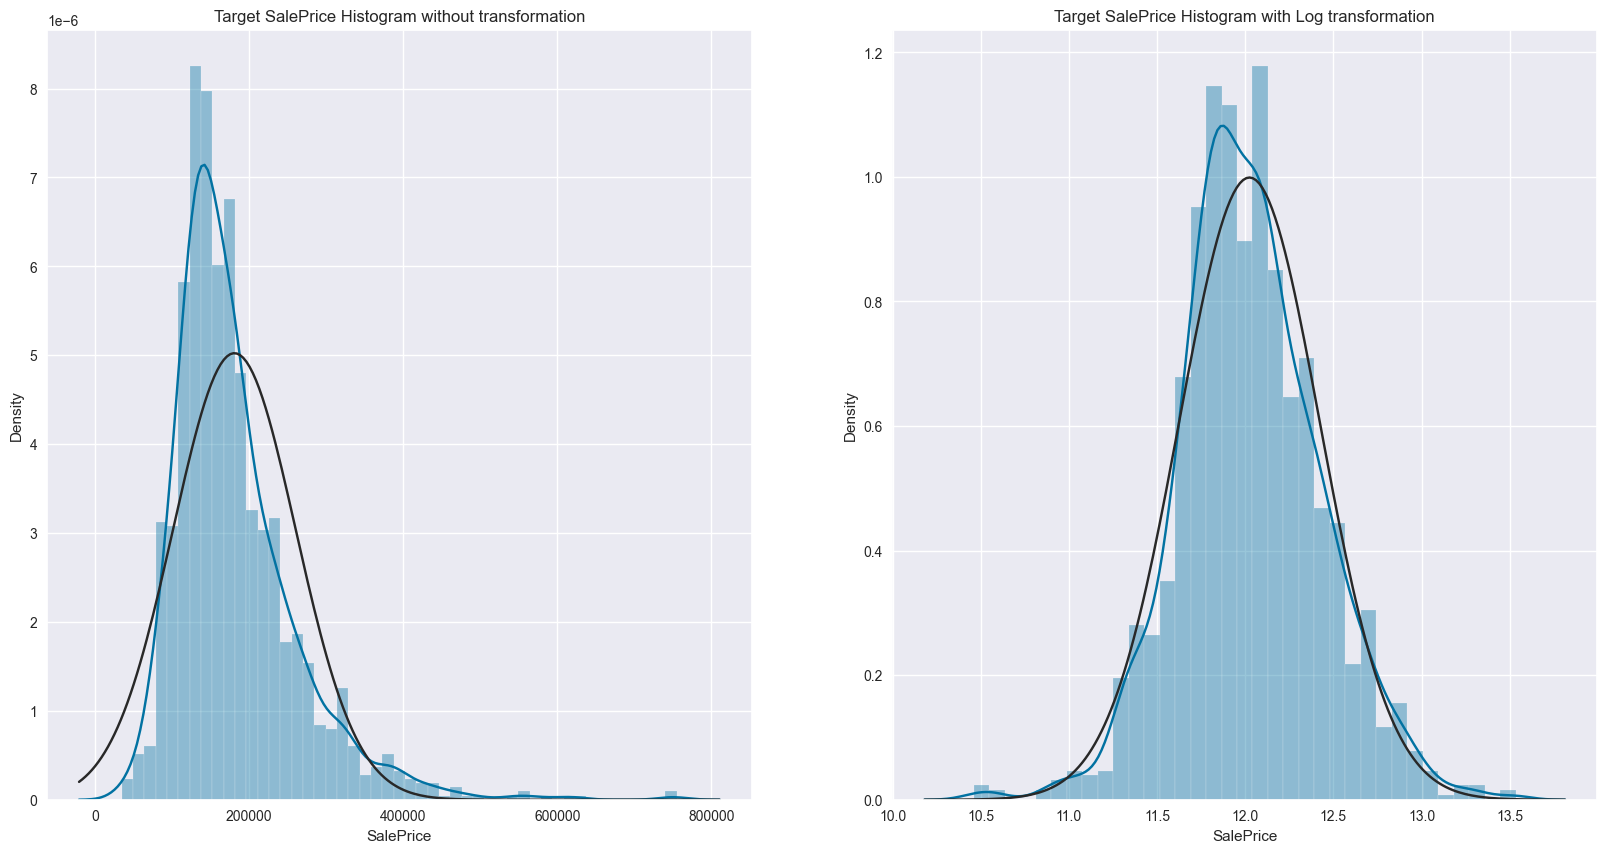

skew stats: 1.880940746034036
skew stats with log transformation: 0.12122191311528363


In [139]:
#target transformation
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.distplot(target, kde =True, fit=stats.norm)
plt.title("Target SalePrice Histogram without transformation")

plt.subplot(1,2,2)
sns.distplot(np.log(target), kde=True, fit=stats.norm)
plt.title("Target SalePrice Histogram with Log transformation")

plt.show()

print("skew stats: {}".format(stats.skew(target))) #1.88
print("skew stats with log transformation: {}".format(stats.skew(np.log1p(target)))) #0.12 -> better one

log_target = np.log(target)

#### 3. Model Selection  ####

In [140]:
#split data 
train_data1 = data3[data3['train_set'] > 0] #We should't normalize train_set. It was a mistake and caused this > 0 and < 0 filter
test_data1 = data3[data3['train_set'] < 0]


In [141]:
#using pycaret to see the best models that fit our data
models_summary = setup(data=pd.concat([train_data1, log_target], axis=1), target='SalePrice')

,Description,Value
0,Session id,2987
1,Target,SalePrice
2,Target type,Regression
3,Original data shape,"(1460, 303)"
4,Transformed data shape,"(1460, 303)"
5,Transformed train set shape,"(1021, 303)"
6,Transformed test set shape,"(439, 303)"
7,Numeric features,302
8,Preprocess,True
9,Imputation type,simple


In [142]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0882,0.0170,0.1287,0.8944,0.0100,0.0074,0.1470
omp,Orthogonal Matching Pursuit,0.0866,0.0176,0.1303,0.8905,0.0101,0.0072,0.1710
gbr,Gradient Boosting Regressor,0.0927,0.0193,0.1373,0.8829,0.0106,0.0078,0.4900
lightgbm,Light Gradient Boosting Machine,0.0944,0.0194,0.1383,0.8822,0.0107,0.0079,0.4990
ridge,Ridge Regression,0.0927,0.0190,0.1364,0.8812,0.0106,0.0078,0.1420
et,Extra Trees Regressor,0.0996,0.0218,0.1464,0.8685,0.0113,0.0083,0.9100
rf,Random Forest Regressor,0.1010,0.0225,0.1486,0.8650,0.0115,0.0085,1.0040
xgboost,Extreme Gradient Boosting,0.1036,0.0225,0.1484,0.8631,0.0115,0.0087,0.7200
ada,AdaBoost Regressor,0.1329,0.0323,0.1789,0.8036,0.0139,0.0111,0.3370
knn,K Neighbors Regressor,0.1471,0.0425,0.2051,0.7414,0.0159,0.0123,0.1960


BayesianRidge()

In [143]:
#training our baseline model with GradientBoostingRegressor
baseline_model = GradientBoostingRegressor()
baseline_model.fit(train_data1, log_target)

#evaluate our model
kf = KFold(n_splits = 10)
results = cross_val_score(baseline_model, train_data1, log_target, scoring='neg_mean_squared_error', cv=kf)

In [144]:
np.exp(np.sqrt(np.mean(-results))) #error in salePrice original unit

1.1359430161793942

#### 4. First Submission ####

In [145]:
baseline_model_pred = baseline_model.predict(test_data1)
sub1 = make_submission(baseline_model_pred).reset_index(drop=True)
sub1.to_csv("submission1.csv", index=False, header=True)

#score: 0.13773, position: 1330


#### 5. Ensemble ####

In [146]:
models = {"GradientBoostingRegressor": GradientBoostingRegressor(),
          "BayesianRidge" : BayesianRidge(),
          "Ridge": Ridge(),
          "Omp": OrthogonalMatchingPursuit(),
          "RandomForestRegressor": RandomForestRegressor()  #low weight
          
}

for name, model in models.items():
    print("{} trained".format(name))
    model.fit(train_data1, log_target)

GradientBoostingRegressor trained
BayesianRidge trained
Ridge trained
Omp trained
RandomForestRegressor trained


In [147]:
results = {}

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_data1, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result

results

{'GradientBoostingRegressor': array([1.1384193 , 1.10804227, 1.11942164, 1.16958313, 1.16735953,
        1.11316725, 1.13928862, 1.1149197 , 1.12366363, 1.14657752]),
 'BayesianRidge': array([1.12260078, 1.10928758, 1.12195311, 1.17317395, 1.1523188 ,
        1.14416651, 1.12700644, 1.1011015 , 1.21373819, 1.13649138]),
 'Ridge': array([1.12860812, 1.11125049, 1.1225425 , 1.17621186, 1.16011636,
        1.16372154, 1.13165443, 1.10125748, 1.22720383, 1.1362898 ]),
 'Omp': array([1.12370536, 1.09810343, 1.11350372, 1.18198409, 1.15966074,
        1.16160327, 1.12650439, 1.1080629 , 1.20368954, 1.12816528]),
 'RandomForestRegressor': array([1.15818696, 1.12711717, 1.14348159, 1.18375841, 1.18276353,
        1.11819207, 1.14555219, 1.12481047, 1.15272975, 1.16614483])}

In [148]:
for name, result in results.items():
    print("Model: {} (std: {}, mean: {})".format(name, np.mean(result), np.std(result)))

Model: GradientBoostingRegressor (std: 1.1340442598105727, mean: 0.020918713388149077)
Model: BayesianRidge (std: 1.1401838234572519, mean: 0.03157929427085268)
Model: Ridge (std: 1.145885640798918, mean: 0.03518841956331649)
Model: Omp (std: 1.1404982732751938, mean: 0.032764073389639124)
Model: RandomForestRegressor (std: 1.1502736960458884, mean: 0.021862335049590197)


#### 6. Second Submission ####

In [149]:
prediction = (
    0.2 * models['GradientBoostingRegressor'].predict(test_data1) +
    0.2 * models['BayesianRidge'].predict(test_data1) +
    0.2 * models['Ridge'].predict(test_data1) +
    0.2 * models['Omp'].predict(test_data1) +
    0.2 * models['RandomForestRegressor'].predict(test_data1) 
              )

sub2 = make_submission(prediction).reset_index(drop=True)
sub2.to_csv("submission2.csv", index=False, header=True)   

#score: 0.12672, position: 645


#### 7. Third Submission ####

In [150]:
#changing weights of models prediction
prediction = (
    0.4 * models['GradientBoostingRegressor'].predict(test_data1) +
    0.2 * models['BayesianRidge'].predict(test_data1) +
    0.2 * models['Ridge'].predict(test_data1) +
    0.1 * models['Omp'].predict(test_data1) +
    0.1 * models['RandomForestRegressor'].predict(test_data1) 
              )

sub3 = make_submission(prediction).reset_index(drop=True)
sub3.to_csv("submission3.csv", index=False, header=True)   

#score: 0.12712 -> worst score


#### 8. Feature Engineering ####

In [151]:
data4 = data3.copy()

#creating new features
data4["SqFtPerRoom"] = data4["GrLivArea"] / (data4["TotRmsAbvGrd"] +
                                                       data4["FullBath"] +
                                                       data4["HalfBath"] +
                                                       data4["KitchenAbvGr"])

data4['Total_Home_Quality'] = data4['OverallQual'] + data4['OverallCond']

data4['Total_Bathrooms'] = (data4['FullBath'] + (0.5 * data4['HalfBath']) +
                               data4['BsmtFullBath'] + (0.5 * data4['BsmtHalfBath']))

data4["HighQualSF"] = data4["1stFlrSF"] + data4["2ndFlrSF"]

In [152]:
train_data2= data4[data3['train_set'] > 0] 
test_data2 = data4[data3['train_set'] < 0]

#training models with our new data
models = {"GradientBoostingRegressor": GradientBoostingRegressor(),
          "BayesianRidge" : BayesianRidge(),
          "Ridge": Ridge(),
          "Omp": OrthogonalMatchingPursuit(),
          "RandomForestRegressor": RandomForestRegressor()  #low weight
          
}

for name, model in models.items():
    print("{} trained".format(name))
    model.fit(train_data2, log_target)

#getting results for our models with our new data
results = {}

for name, model in models.items():
    result = np.exp(np.sqrt(-cross_val_score(model, train_data2, log_target, scoring='neg_mean_squared_error', cv=kf)))
    results[name] = result



GradientBoostingRegressor trained
BayesianRidge trained
Ridge trained
Omp trained
RandomForestRegressor trained


#### 9. Forth Submission ####

In [153]:
prediction = (
    0.2 * models['GradientBoostingRegressor'].predict(test_data2) +
    0.2 * models['BayesianRidge'].predict(test_data2) +
    0.2 * models['Ridge'].predict(test_data2) +
    0.2 * models['Omp'].predict(test_data2) +
    0.2 * models['RandomForestRegressor'].predict(test_data2) 
              )

sub4 = make_submission(prediction).reset_index(drop=True)
sub4.to_csv("submission4.csv", index=False, header=True)   

#score: 0.12635, final position: 627/ 4202